# CLS & SEP study
- objectif : see if the CLS token has the effect of a trash in our model. We wan't to understand how the model is actually really working.

In [1]:
%load_ext autoreload
%autoreload 2

import os
from os import path

# set the repository to the git repository
cwd = os.getcwd().split(os.path.sep)
while cwd[-1] != "stage_4_gm":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)
print(">> the git rep : ", end="")
print(os.getcwd())

# the folder where we will save our data
plots_folder = os.path.join(os.getcwd(), '.cache', 'plots')
graph_folder = path.join(plots_folder, "sep_cls_study")
if not path.exists(path.join(plots_folder, "sep_cls_study")):
    os.mkdir(path.join(plots_folder, "sep_cls_study"))

print(f">> the plots location : {graph_folder}")

>> the git rep : C:\Users\loicf\Documents\IRISA\stage_4_gm\stage_4_gm
>> the plots location : C:\Users\loicf\Documents\IRISA\stage_4_gm\stage_4_gm\.cache\plots\sep_cls_study


In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
import sklearn.metrics as metrics
import random

from training_bert import BertNliLight
from custom_data_set import SnliDataset
from custom_data_set import test_dir, dev_dir
from torch.utils.data import DataLoader
from tqdm import tqdm
import pickle

# --> from this environment
from attention_algorithms.raw_attention import RawAttention
from attention_algorithms.attention_metrics import normalize_attention
from attention_algorithms.attention_metrics import default_plot_colormap
from attention_algorithms.attention_metrics import attention_score

# --> display HTML outputs
from attention_algorithms.plausibility_visu import construct_html_table
from attention_algorithms.plausibility_visu import hightlight_txt
from IPython.display import display, HTML
from ipywidgets import interact_manual

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
ckp = path.join(".cache", "logs", "igrida_trained", "0", "best.ckpt")
model = BertNliLight.load_from_checkpoint(ckp)
model = model.eval()  # make sure to have the model in eval mod before using it

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
# load the data
data_set = SnliDataset(dir=test_dir, nb_sentences=1000, msg=False, keep_neutral=False)
data_loader = DataLoader(data_set, batch_size=1000, shuffle=False)
sentences, masks, train_labels = next(iter(data_loader))

In [5]:
# the data we annotated.
e_snli_data = pd.read_csv(os.path.join('.cache', 'raw_data', 'e_snli', 'cleaned_data', 'test.csv'), sep=",") \
[["tok_sent", "hg_goal", "label"]]
e_snli_data.head()

,tok_sent,hg_goal,label
0,"['[CLS]', 'this', 'church', 'choir', 'sings', ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",neutral
1,"['[CLS]', 'this', 'church', 'choir', 'sings', ...","[0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",entailment
2,"['[CLS]', 'this', 'church', 'choir', 'sings', ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",contradiction
3,"['[CLS]', 'a', 'woman', 'with', 'a', 'green', ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",neutral
4,"['[CLS]', 'a', 'woman', 'with', 'a', 'green', ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",entailment


In [17]:
pur_attention, Y_test = None, None
auc_path = graph_folder = path.join(plots_folder, "auc_head_map")
dir = os.path.join(auc_path, "inference_dict.pickle")

if os.path.exists(dir) and os.path.getsize(dir) != 0:
    print(">> the files already exist in the environment >> loading the files ...", end="")
    with open(os.path.join(graph_folder, "inference_dict.pickle"), "rb") as f:
        pur_attention, Y_test = pickle.load(f)
    print(" loading finished")
else:
    with open(os.path.join(graph_folder, "inference_dict.pickle"), "wb") as f:
        pur_attention, Y_test, _ = attention_score(sentences=sentences, masks=masks,
                                                   e_snli_data=e_snli_data,
                                                   model=model, TR_q=0,
                                                   quantiles_calc=False)

        pickle.dump([pur_attention, Y_test], f)

>> the files already exist in the environment >> loading the files ... loading finished


In [6]:
sent_choice = [random.randint(0, 1000) for _ in range(100)]
print(f">> we will look at the sentence : {sent_choice}")

>> we will look at the sentence : [688, 847, 937, 393, 948, 640, 907, 649, 628, 966, 486, 119, 405, 735, 806, 282, 732, 466, 396, 533, 943, 899, 317, 356, 97, 393, 538, 417, 82, 912, 982, 975, 53, 420, 968, 890, 11, 458, 206, 681, 415, 288, 357, 938, 981, 334, 777, 697, 622, 190, 226, 933, 938, 564, 962, 745, 284, 633, 22, 759, 612, 316, 768, 908, 76, 30, 646, 613, 694, 275, 726, 486, 570, 804, 77, 57, 547, 623, 166, 900, 255, 244, 329, 930, 446, 706, 38, 995, 620, 336, 627, 943, 285, 602, 702, 545, 325, 378, 800, 100]


In [8]:
# This time we will keep the specials tokens to see what will happen
search = ["entailment", "neutral", "contradiction"]
plausible_map = np.zeros((12, 12))
annot = []
jc = []
x = []
for k in tqdm(sent_choice):
    try:
        buff_dict = {}
        sent = sentences[k, :].clone().detach()[None, :]
        mk = masks[k, :].clone().detach()[None, :]
        raw_attention_inst = RawAttention(model=model,
                                          input_ids=sent,
                                          attention_mask=mk,
                                          test_mod=False
                                          )

        b = model(input_ids = sent,
                  attention_mask = mk)
        lab = torch.argmax(b["logits"][0])
        lab = search[lab]
        # we will now earch the e-snli corresponding sentence
        j = 0

        while eval(e_snli_data["tok_sent"][j]) != raw_attention_inst.tokens:
            j += 1

        buff_dict["annotation"] = hightlight_txt(raw_attention_inst.tokens,
                                                 torch.tensor(eval(e_snli_data.hg_goal[j])))
        attention_score = torch.zeros(len(raw_attention_inst.tokens))
        for layer in range(12):
            for head in range(12):
                buff = raw_attention_inst.attention_tensor[0, layer, head, 0, :]
                used = False
                for t in range(len(raw_attention_inst.tokens)):
                    if raw_attention_inst.tokens[t] == '[SEP]' and buff[t] <= 0.001:
                        attention_score = attention_score + buff
                        used = True
                        continue
                if used:
                    plausible_map[layer, head] += 1
        attention_score = normalize_attention(tokens=raw_attention_inst.tokens,
                                              attention=attention_score).detach().numpy()

        buff_dict[f"SEP"] = hightlight_txt(attention=attention_score,
                                           tokens=raw_attention_inst.tokens)

        buff_dict['prediction'] = lab
        buff_dict['real_lab'] = train_labels[k]
        buff_dict['e_snli_label'] = e_snli_data.label[j]

        annot.append(buff_dict)

    except Exception as e:
        pass

#display(HTML(construct_html_table(annot[0].keys(), annot)))

100%|██████████| 100/100 [00:42<00:00,  2.36it/s]


In [9]:
display(HTML(construct_html_table(annot[0].keys(), annot[:10])))

annotation,SEP,prediction,real_lab,e_snli_label
[CLS] a group of friends are sitting at a table while drinking alcohol at their local pub . [SEP] a group of friends are at the table [SEP],[CLS] a group of friends are sitting at a table while drinking alcohol at their local pub . [SEP] a group of friends are at the table [SEP],entailment,0,entailment
[CLS] a man is watching as a woman is reading a piece of paper . [SEP] a woman watches as a man reads a paper . [SEP],[CLS] a man is watching as a woman is reading a piece of paper . [SEP] a woman watches as a man reads a paper . [SEP],contradiction,2,contradiction
[CLS] two young girls hang tin ##sel on a christmas tree in a room with blue curtains . [SEP] two girls are in a room with red curtains . [SEP],[CLS] two young girls hang tin ##sel on a christmas tree in a room with blue curtains . [SEP] two girls are in a room with red curtains . [SEP],contradiction,2,contradiction
"[CLS] couples enjoying a meal , while a bunch of dogs take a nap . [SEP] there is a couple walking their dogs [SEP]","[CLS] couples enjoying a meal , while a bunch of dogs take a nap . [SEP] there is a couple walking their dogs [SEP]",contradiction,2,contradiction
[CLS] shipyard workers are standing around . [SEP] shipyard workers are un ##loading the ships [SEP],[CLS] shipyard workers are standing around . [SEP] shipyard workers are un ##loading the ships [SEP],neutral,2,contradiction
[CLS] a lion ##ess closes in on its prey . [SEP] a lion ##ess prey ##ing [SEP],[CLS] a lion ##ess closes in on its prey . [SEP] a lion ##ess prey ##ing [SEP],entailment,0,entailment
[CLS] mom and little boy having fun & eating by the lake . [SEP] a mom is pouring grape juice on the ground while her son is crying . [SEP],[CLS] mom and little boy having fun & eating by the lake . [SEP] a mom is pouring grape juice on the ground while her son is crying . [SEP],contradiction,2,contradiction
[CLS] a skate ##board ##er with a black and white hat at the top of a jump on a snowy day . [SEP] a skate ##board ##er is outdoors . [SEP],[CLS] a skate ##board ##er with a black and white hat at the top of a jump on a snowy day . [SEP] a skate ##board ##er is outdoors . [SEP],entailment,0,entailment
[CLS] a man with a red helmet and numbers on his arm and leg is riding a red racing bike . [SEP] a tall man is sitting on a swings ##et in a deserted park . [SEP],[CLS] a man with a red helmet and numbers on his arm and leg is riding a red racing bike . [SEP] a tall man is sitting on a swings ##et in a deserted park . [SEP],contradiction,2,contradiction
[CLS] three hike ##rs and a dog are walking through the foliage on the hillside . [SEP] people are outside . [SEP],[CLS] three hike ##rs and a dog are walking through the foliage on the hillside . [SEP] people are outside . [SEP],entailment,0,entailment


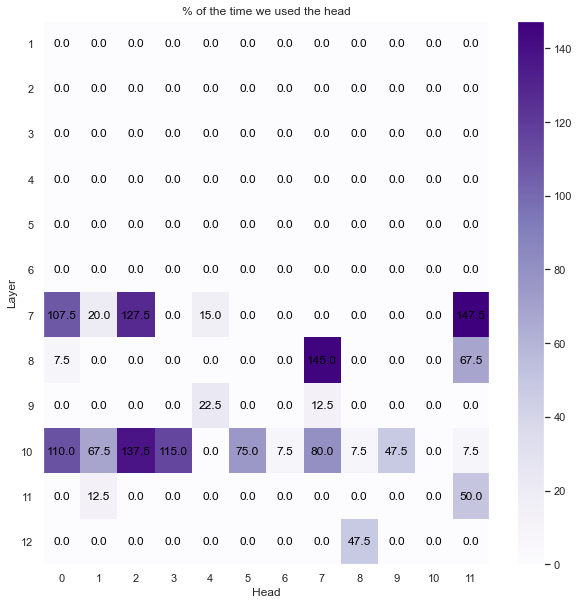

In [10]:
fig = default_plot_colormap(plausible_map/40 * 100, xlabel="Head", ylabel="Layer", title="% of the time we used the head")
plt.savefig(os.path.join(graph_folder, "plausible_map.png"))